In [2]:
import math
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import seaborn as sns
import matplotlib.pyplot as plt
from sindy_rl_functions_ema import *

In [5]:
data = pd.read_csv('GBE_final.csv')

data = data[['participant', 'attempt number', 'happiness rating', 'certain reward', 'expected value', 'prediction error', 'CR gamma4', 'CR gamma6', 'CR gamma8', 'EV gamma4', 'EV gamma6', 'EV gamma8', 'PE gamma4', 'PE gamma6', 'PE gamma8', 'H gamma4', 'H gamma6', 'H gamma8', 'dCR4', 'dCR6', 'dCR8', 'dEV4', 'dEV6', 'dEV8', 'dPE4', 'dPE6', 'dPE8', 'dH4', 'dH6', 'dH8', 'Cl1', 'Cc1']]

data.to_csv("GBE_SINDy_Final.csv", index=False, header=True)

In [3]:
#prepping data for stan
frame = pd.read_csv('Data/GBE_Data.csv')

frame = frame[frame['attempt number'] < 2]

result = frame[['participant', 'happiness rating', 'certain reward', 'expected value', 'prediction error']]

result.to_csv("GBE_Stan_Final_NS.csv", index=False, header=True)


In [9]:
#sindy analysis

from matplotlib.pylab import LinAlgError


r2list = []
folds = 1

collect = ['CR', 'EV', 'PE']

occurences = [0 for i in collect]
occurences.append(0)
occurences.append(0)
   

myvar = ['happiness rating']

# Rutledge derivative values
controlvars = ['dCR4', 'dCR6', 'dCR8', 'dEV4', 'dEV6', 'dEV8', 'dPE4', 'dPE6', 'dPE8']
        
qvalslist = []
control_inputs_training = []
participants= []

data = pd.read_csv('GBE_SINDy_final.csv')

data = data[data['attempt number'] < 2]
data.dropna(subset=['happiness rating'], inplace=True)
list_df2 = []
for i in range (1, 50000):
    df1 = data[data['participant'] == i]
    if len(df1) > 0:
            list_df2.append(df1)
            participants.append(i)
print(len(list_df2))
for df in list_df2:
    control_inputs_training.append(np.array(df[controlvars])[0:])
    qvalslist.append(np.array(df[myvar])[0:])


generalized_library, feat_names = SINDYlibrary(myvar, controlvars)
print(feat_names)
repeats = []
exceptionlist = []
coefficient_totals=[[] for i in collect]


for i in range (0,16337):
    
    save = -1
    count = 1
    good = True
    for num in qvalslist[i]:
         if count > 6:
              good = False
              repeats.append(i)
              break
         elif num == save:
              count += 1
         else:
              count = 1
              save = num

    if good:
        print(i)

        newQ = []
        newC = []
        newQ.append(qvalslist[i])
        newC.append(control_inputs_training[i])

        test = [i for i, x in enumerate(newQ)]
        np.random.seed(100)
        np.random.shuffle(test)

        holdoutsize = 0

        print(len(qvalslist))
        for kfold in range(0, folds):
            leaveout = [] 
            try:
                model, r2, coefficients = testSINDy(newQ, newC,
                                generalized_library, feat_names, leaveout=leaveout, testing=True, runs=1, errperc=0.005, collect=collect)
                r2list.append(r2)
                totals = coefficients[0]
                values = coefficients[1]
                for i in range(0, len(totals)):
                     if(totals[i] == True):
                         occurences[i] += 1
                for i in range(0, len(values)):
                     coefficient_totals[i].append(values[i])

            except LinAlgError:
                exceptionlist.append(i)
                continue
            
print(len(r2list))
print(sum(r2list) // len(r2list))
print(occurences[0])  
print(occurences[1])
print(occurences[2]) 
         


16337
['happiness rating', 'dCR4', 'dCR6', 'dCR8', 'dEV4', 'dEV6', 'dEV8', 'dPE4', 'dPE6', 'dPE8']
0
16337
R^2 = 0.3072883599732058
(happiness rating)' = 0.244 dCR4 + -0.125 dCR8 + 0.096 dEV4 + 0.128 dPE6
1
16337
R^2 = 0.2791093591792212
(happiness rating)' = -0.120 dCR4 + 0.084 dCR6 + 0.248 dCR8 + -0.056 dPE4 + 0.032 dPE8
2
16337
R^2 = 0.373875400459477
(happiness rating)' = 0.140 dCR6 + -0.090 dEV8 + -0.193 dPE4 + -0.094 dPE6 + 0.131 dPE8
3
16337
R^2 = 0.2940212105684106
(happiness rating)' = -0.046 dCR4 + 0.045 dCR8 + 0.025 dEV4 + -0.055 dEV8 + -0.042 dPE4 + 0.072 dPE8
4
16337
R^2 = 0.5262276834321166
(happiness rating)' = 0.299 dCR8 + -0.032 dEV4 + 0.078 dEV8 + -0.109 dPE4 + 0.095 dPE8
5
16337
R^2 = 0.4901747447912046
(happiness rating)' = -0.355 dCR4 + 0.433 dCR8 + 0.536 dEV8 + 0.520 dPE8
6
16337
R^2 = 0.3570773162665024
(happiness rating)' = -0.035 dCR4 + -0.042 dCR8 + -0.020 dEV4 + -0.018 dPE4 + 0.023 dPE8
7
16337
R^2 = 0.6335548075188793
(happiness rating)' = -0.040 dCR4 + 0.06

In [10]:
print(np.median(r2list))
newlist = []
for i in r2list:
    if i < 0:
        #continue
        newlist.append(0)
    else:
        newlist.append(i)
print(len(newlist))
np.mean(newlist)


0.4319991553709245
14039


0.4305660483886583

In [11]:
print(exceptionlist)
print(repeats)

repeat_H_excluded = []

repeat_gamble_excluded = []

for i in exceptionlist:
    repeat_gamble_excluded.append(participants[i+1])

for i in repeats:
    repeat_H_excluded.append(participants[i+1])

[41, 60, 63, 79, 81, 162, 172, 234, 256, 258, 269, 291, 360, 362, 366, 419, 421, 422, 434, 465, 485, 494, 509, 537, 545, 549, 579, 585, 599, 666, 670, 753, 764, 769, 789, 833, 858, 859, 868, 899, 914, 918, 948, 978, 1010, 1021, 1043, 1046, 1057, 1155, 1195, 1205, 1232, 1243, 1260, 1264, 1267, 1274, 1296, 1310, 1366, 1382, 1407, 1447, 1474, 1492, 1509, 1572, 1598, 1608, 1717, 1736, 1742, 1799, 1807, 1823, 1838, 1852, 1857, 1860, 1861, 1870, 1872, 1874, 1895, 1913, 1929, 1940, 1952, 1972, 1989, 1997, 2006, 2011, 2022, 2031, 2044, 2064, 2085, 2088, 2103, 2110, 2153, 2177, 2189, 2193, 2195, 2228, 2252, 2259, 2314, 2315, 2319, 2407, 2416, 2427, 2433, 2454, 2464, 2491, 2497, 2502, 2528, 2538, 2559, 2577, 2598, 2604, 2640, 2645, 2657, 2688, 2689, 2720, 2731, 2742, 2763, 2801, 2815, 2863, 2888, 2893, 2896, 2902, 2905, 2947, 2953, 2968, 2972, 3007, 3027, 3045, 3073, 3089, 3100, 3132, 3180, 3194, 3208, 3235, 3236, 3285, 3300, 3351, 3390, 3395, 3417, 3445, 3454, 3466, 3492, 3503, 3509, 3526, 3547

[0.119, 0.21200000000000002, 0.14, -0.0010000000000000009, 0.299, 0.07800000000000001, -0.07700000000000001, 0.019999999999999997, -0.166, -0.028999999999999998, -0.006000000000000002, -0.05, -0.07, -0.031, 0.345, 0.10999999999999999, 0.01, -0.16199999999999998, -0.153, 0.376, 0.014000000000000002, 0.078, 0.299, -0.01, 0.568, -0.0050000000000000044, -0.016, 0.105, -0.192, -0.28200000000000003, -0.03199999999999997, -1.476, -0.081, 0.037000000000000005, -0.177, 0.033, 0, 0.076, 0.17999999999999994, -0.007, 0, 0.051000000000000004, -0.012, 0.184, -0.092, 0.08399999999999999, 0.014000000000000002, 0.068, 0.038, 0.175, -0.020999999999999998, -0.138, 0.9089999999999998, 0.04, 0.26, 0.393, 0.169, -0.009, 0.05700000000000001, -0.13799999999999998, 0.048, 0.047, 0.04, -0.573, 0.05, -0.058, 0.119, 0.133, 0.23, 0.075, 0.464, 0.089, -0.06, 0.04, -0.02, -0.781, -0.438, 0.091, 0.018000000000000002, 0.059, -0.036, 0.048, 0.45299999999999996, 0.023, 0, 0.022, -0.016, 0.14300000000000002, 0.0360000000

<Axes: xlabel='Variables', ylabel='Values'>

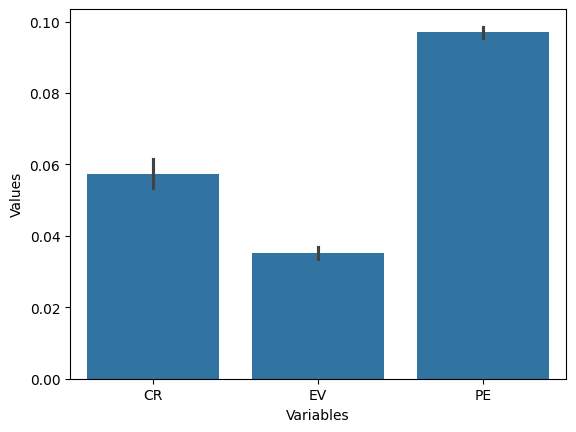

In [12]:
CR = np.mean(coefficient_totals[0])
print(coefficient_totals[0])
print(CR)
EV = np.mean(coefficient_totals[1])
PE = np.mean(coefficient_totals[2])
means =[CR, EV, PE]

variables = []
vals=[]
for i in range(0, len(coefficient_totals)):
    variables += len(coefficient_totals[i])*[collect[i]]
    vals += coefficient_totals[i]
data = {
    "Variables":variables,
    "Values":vals
}

sns.barplot(data=data, x ="Variables", y="Values", errorbar="se")


In [15]:
#sindy analysis 2

from matplotlib.pylab import LinAlgError


r2list2 = []
folds = 1

collect = ['CR', 'EV', 'PE', 'H', 'Cl1', 'Cc1']

occurences = [0 for i in collect]
occurences.append(0)
occurences.append(0)
   

myvar = ['happiness rating']


controlvars = ['dCR4', 'dCR6', 'dCR8', 'dEV4', 'dEV6', 'dEV8', 'dPE4', 'dPE6', 'dPE8', 'dH4', 'dH6', 'dH8', 'Cl1', 'Cc1']
       
        
qvalslist = []
control_inputs_training = []
participants= []

data = pd.read_csv('GBE_SINDy_final.csv')

data = data[data['attempt number'] < 2]
data.dropna(subset=['happiness rating'], inplace=True)
list_df2 = []
for i in range (1, 50000):
    df1 = data[data['participant'] == i]
    if len(df1) > 0:
            list_df2.append(df1)
            participants.append(i)
print(len(list_df2))
for df in list_df2:
    control_inputs_training.append(np.array(df[controlvars])[0:])
    qvalslist.append(np.array(df[myvar])[0:])


generalized_library, feat_names = SINDYlibrary(myvar, controlvars)
print(feat_names)
repeats = []
exceptionlist = []
coefficient_totals=[[] for i in collect]


for i in range (0,16337):
    
    save = -1
    count = 1
    good = True
    for num in qvalslist[i]:
         if count > 6:
              good = False
              repeats.append(i)
              break
         elif num == save:
              count += 1
         else:
              count = 1
              save = num

    if good:
        print(i)

        newQ = []
        newC = []
        newQ.append(qvalslist[i])
        newC.append(control_inputs_training[i])

        test = [i for i, x in enumerate(newQ)]
        np.random.seed(100)
        np.random.shuffle(test)

        holdoutsize = 0

        print(len(qvalslist))
        for kfold in range(0, folds):
            leaveout = [] 
            try:
                model, r2, coefficients = testSINDy(newQ, newC,
                                generalized_library, feat_names, leaveout=leaveout, testing=True, runs=1, errperc=0.005, collect=collect)
                r2list2.append(r2)
                totals = coefficients[0]
                values = coefficients[1]
                for i in range(0, len(totals)):
                     if(totals[i] == True):
                         occurences[i] += 1
                for i in range(0, len(values)):
                     coefficient_totals[i].append(values[i])

            except LinAlgError:
                exceptionlist.append(i)
                continue
            
print(len(r2list2))
print(sum(r2list2) // len(r2list2))
print(occurences[0])  
print(occurences[1])
print(occurences[2]) 
print(occurences[3]) 
print(occurences[4]) 
print(occurences[5]) 
         


16337
['happiness rating', 'dCR4', 'dCR6', 'dCR8', 'dEV4', 'dEV6', 'dEV8', 'dPE4', 'dPE6', 'dPE8', 'dH4', 'dH6', 'dH8', 'Cl1', 'Cc1']
0
16337
R^2 = 0.5576601095477334
(happiness rating)' = 0.189 dCR4 + -0.058 dCR8 + 0.092 dEV4 + -0.059 dEV8 + 0.251 dPE8 + 0.272 Cl1 + 0.014 Cc1
1
16337
R^2 = 0.7468170615917331
(happiness rating)' = 0.063 dCR6 + -0.032 dEV4 + -0.041 dEV6 + -0.028 dPE4 + -0.015 dPE6 + 0.027 dPE8 + 0.053 dH4 + -0.317 dH8
2
16337
R^2 = 0.722644662630854
(happiness rating)' = -0.143 dEV8 + -0.095 dPE4 + -0.082 dPE6 + 0.034 dPE8 + 0.175 dH6 + 0.593 Cl1 + 0.059 Cc1
3
16337
R^2 = 0.6045156706285012
(happiness rating)' = 0.045 dCR6 + 0.063 dCR8 + 0.010 dEV4 + -0.037 dEV8 + -0.038 dPE4 + 0.055 dPE8 + 0.222 dH4 + -0.089 dH8 + 0.322 Cl1 + 0.477 Cc1
4
16337
R^2 = 0.6776805548727217
(happiness rating)' = 0.138 dCR6 + 0.186 dCR8 + -0.060 dEV4 + 0.080 dEV8 + -0.099 dPE4 + 0.095 dPE8 + 0.175 dH4 + -0.038 Cl1 + 0.024 Cc1
5
16337
R^2 = 0.81313798877458
(happiness rating)' = 0.129 dCR6 + 0

In [16]:
print(np.median(r2list2))
newlist2 = []
for i in r2list2:
    if i < 0:
        #continue
        newlist2.append(0)
    else:
        newlist2.append(i)
print(len(newlist2))
np.mean(newlist2)

0.7372381607910237
14039


0.714141776176603

<Axes: xlabel='Variables', ylabel='Values'>

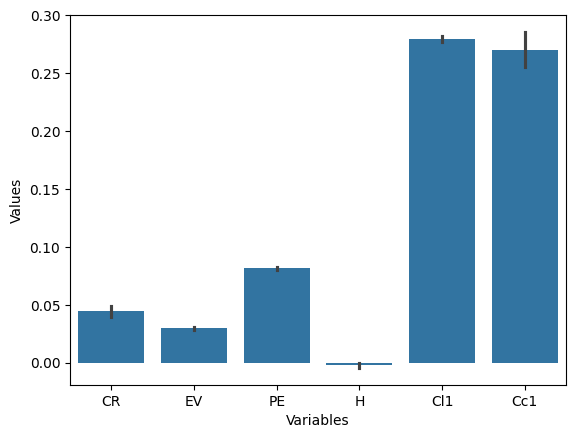

In [17]:
variables = []
vals=[]
for i in range(0, len(coefficient_totals)):
    variables += len(coefficient_totals[i])*[collect[i]]
    vals += coefficient_totals[i]
data = {
    "Variables":variables,
    "Values":vals
}

sns.barplot(data=data, x ="Variables", y="Values", errorbar="se")

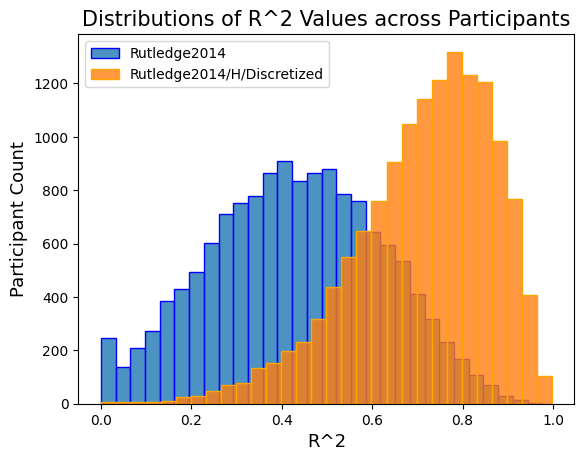

In [18]:
sns.histplot(newlist, alpha=0.8, bins=30, edgecolor='blue',
         label='Rutledge2014')
sns.histplot(newlist2, alpha=0.8, bins=30, edgecolor='orange',
         label='Rutledge2014/H/Discretized')

plt.title('Distributions of R^2 Values across Participants', fontsize=15)
plt.xlabel('R^2', fontsize=13)
plt.ylabel('Participant Count', fontsize=13)

plt.legend()
